Pairwise Target Consistency Analysis
Folder: ../outputs
----------------------------------------
Found 21 variations


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


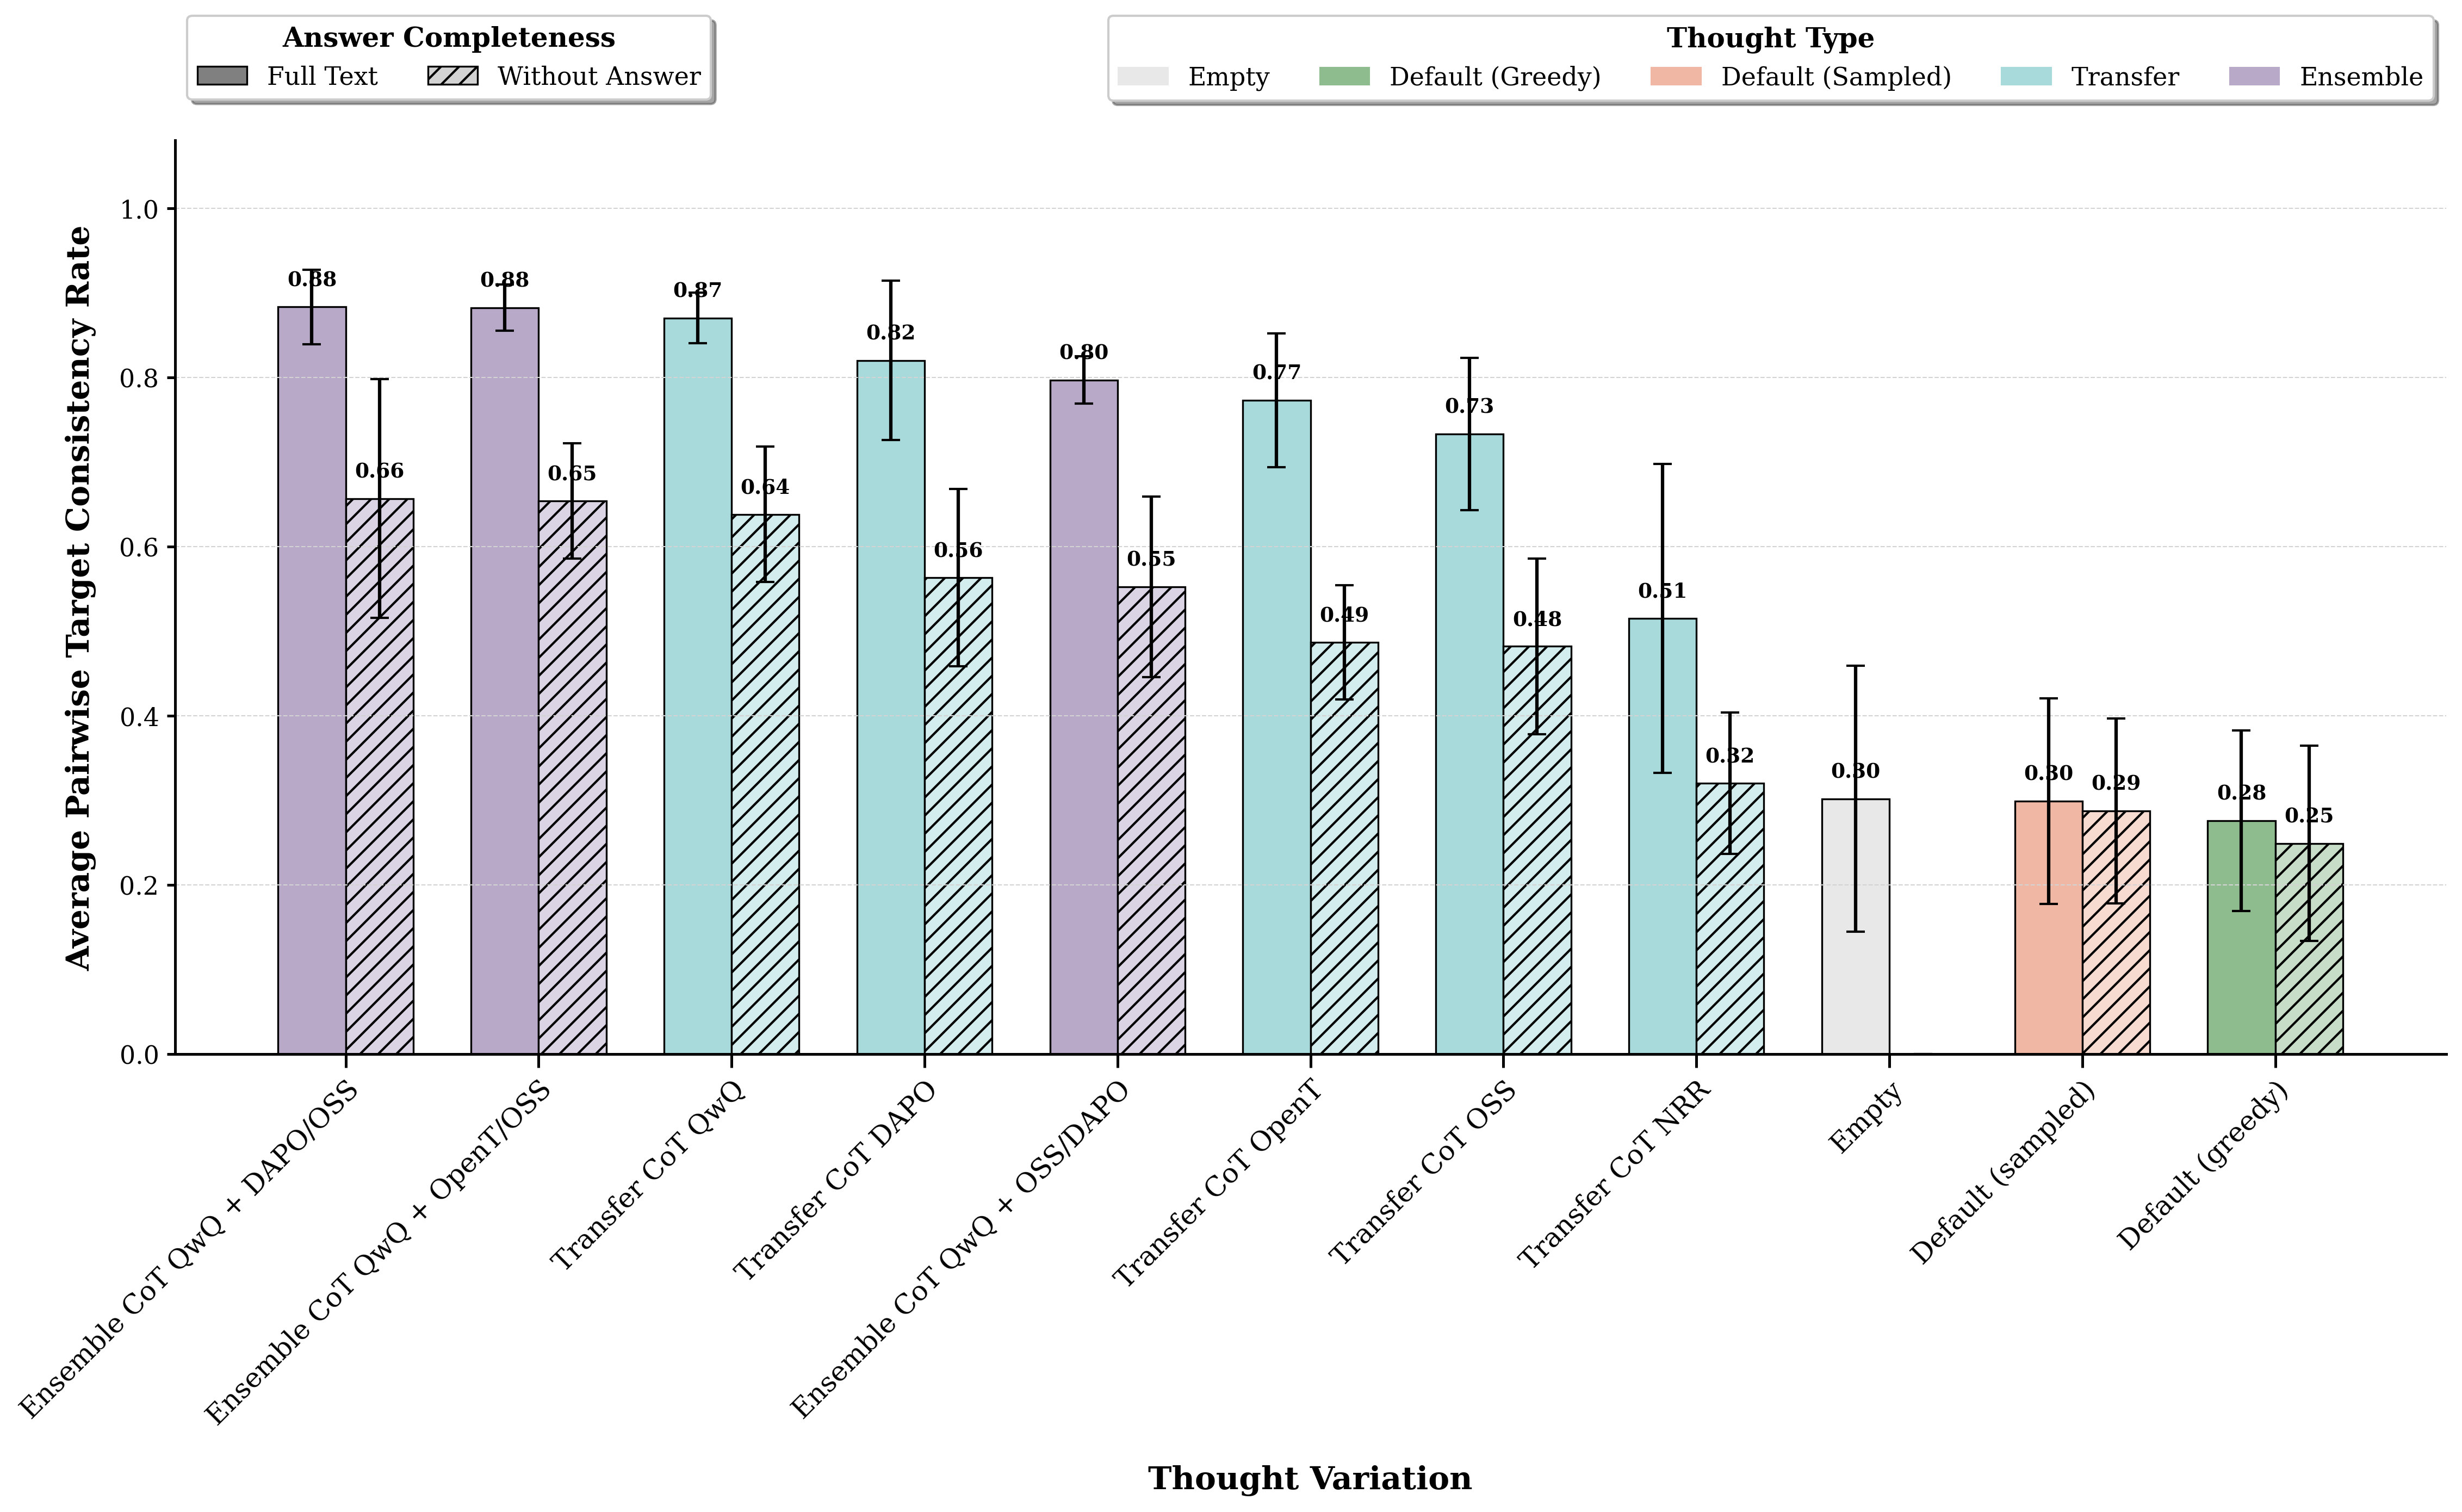


PAIRWISE TARGET CONSISTENCY ANALYSIS
 1. Ensemble CoT QwQ + DAPO/OSS
     Full Text:   0.883 ± 0.044 (n=10)
     Without Ans: 0.657 ± 0.141 (n=10)
     Difference:  +0.226

 2. Ensemble CoT QwQ + OpenT/OSS
     Full Text:   0.882 ± 0.027 (n=10)
     Without Ans: 0.654 ± 0.068 (n=10)
     Difference:  +0.229

 3. Transfer CoT QwQ
     Full Text:   0.870 ± 0.030 (n=10)
     Without Ans: 0.638 ± 0.080 (n=10)
     Difference:  +0.232

 4. Transfer CoT DAPO
     Full Text:   0.820 ± 0.094 (n=10)
     Without Ans: 0.563 ± 0.105 (n=10)
     Difference:  +0.257

 5. Ensemble CoT QwQ + OSS/DAPO
     Full Text:   0.797 ± 0.028 (n=10)
     Without Ans: 0.552 ± 0.107 (n=10)
     Difference:  +0.245

 6. Transfer CoT OpenT
     Full Text:   0.773 ± 0.079 (n=10)
     Without Ans: 0.487 ± 0.068 (n=10)
     Difference:  +0.286

 7. Transfer CoT OSS
     Full Text:   0.733 ± 0.090 (n=10)
     Without Ans: 0.482 ± 0.104 (n=10)
     Difference:  +0.251

 8. Transfer CoT NRR
     Full Text:   0.515 ± 0.1

In [6]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'DejaVu Serif'],
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300
})

MODEL_NAMES = {
    'openai_gpt-oss-20b': 'OSS',
    'BytedTsinghua-SIA_DAPO-Qwen-32B': 'DAPO', 
    'Qwen_QwQ-32B': 'QwQ',
    'open-thoughts_OpenThinker-7B': 'OpenT',
    'nvidia_Nemotron-Research-Reasoning-Qwen-1.5B': 'NRR'
}

COLORS = {
    'empty': '#E8E8E8',
    'default (greedy)': '#8FBC8F', 
    'default (sampled)': '#F0B7A4',
    'transfer': '#A8DADC', 
    'ensemble': '#B8A9C9'
}

def parse_jsonl(filepath):
    """Parse JSONL file and return list of dictionaries."""
    try:
        with open(filepath, 'r') as f:
            return [json.loads(line) for line in f if line.strip()]
    except:
        return []

def get_variation(filename):
    """Extract variation type from filename."""
    suffix = 'without ans' if 'without_answer' in filename else 'full text'
    
    if '_zero_shot_empty.jsonl' in filename:
        return ['Empty']
    elif '_zero_shot_original.jsonl' in filename or '_zero_shot_original_low.jsonl' in filename:
        return [f'Default (greedy) {suffix}']
    elif '_with_sampling' in filename:
        return [f'Default (sampled) {suffix}']
    
    # Transfer CoT
    match = re.match(r'(.+)_thoughts_to_(.+)_zero_shot', filename)
    if match:
        source, target = match.groups()
        short_source = MODEL_NAMES.get(source, source)
        if source == target and "without_answer" in filename:
            return [f'Default (greedy) {suffix}', f'Transfer CoT {short_source} {suffix}']
        else:
            return [f'Transfer CoT {short_source} {suffix}']
    
    # Ensemble CoT
    if '_gen_' in filename and '_eval_' in filename:
        gen = re.search(r'_gen_(.+)_eval', filename)
        eval_match = re.search(r'_eval_(.+).json', filename)
        if gen and eval_match:
            gen_short = MODEL_NAMES.get(gen.group(1), gen.group(1))
            eval_short = MODEL_NAMES.get(eval_match.group(1), eval_match.group(1))
            
            # Handle special combinations
            gen_mappings = {
                "qwq_dapo": "QwQ + DAPO",
                "qwq_opent": "QwQ + OpenT", 
                "qwq_oss": "QwQ + OSS"
            }
            gen_short = gen_mappings.get(gen_short, gen_short)
            eval_short = {"oss": "OSS", "dapo": "DAPO"}.get(eval_short, eval_short)
            
            return [f'Ensemble CoT {gen_short}/{eval_short} {suffix}']
    
    return []

def get_target_model(filename):
    """Extract target model from filename."""
    if '_thoughts_to_' in filename:
        match = re.match(r'.+_thoughts_to_(.+)_zero_shot', filename)
        return match.group(1) if match else None
    
    for model in MODEL_NAMES:
        if model in filename:
            return model
    return None

def check_consistency(dp1, dp2, is_thoughts_to):
    """Check consistency between two data points."""
    fields = ("Target Answer", "Target Result") if is_thoughts_to else ("LLM Answer", "Result")
    ans1, res1 = dp1.get(fields[0], ""), dp1.get(fields[1], "")
    ans2, res2 = dp2.get(fields[0], ""), dp2.get(fields[1], "")
    
    invalid = ["not defined", "N/A", "does not match", "are not permitted"]
    if any(p in ans1 or p in ans2 for p in invalid):
        return None
    
    return 1 if ans1 == ans2 or (res1 == "Correct" and res2 == "Correct") else 0

def calculate_pairwise_consistency(folder_path):
    """Calculate pairwise consistency for all variations."""
    if not os.path.exists(folder_path):
        return {}
    
    variation_files = defaultdict(list)
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jsonl'):
            continue
        if "grpo" in filename.lower():
            continue
        if "meta-llama" in filename.lower():
            continue
        if "deepseek" in filename.lower():
            continue
            
        variations = get_variation(filename)
        target = get_target_model(filename)
        
        if variations and target:
            for variation in variations:
                variation_files[variation].append((target, filename))
    
    results = {}
    for variation, files in variation_files.items():
        if len(files) < 2:
            continue
            
        rates = []
        is_thoughts_to = '_thoughts_to_' in files[0][1]
        
        for i in range(len(files)):
            for j in range(i + 1, len(files)):
                data1 = parse_jsonl(os.path.join(folder_path, files[i][1]))
                data2 = parse_jsonl(os.path.join(folder_path, files[j][1]))
                
                if not data1 or not data2:
                    continue
                
                consistent = total = 0
                for dp1, dp2 in zip(data1, data2):
                    result = check_consistency(dp1, dp2, is_thoughts_to)
                    if result is not None:
                        total += 1
                        consistent += result
                
                if total > 0:
                    rates.append(consistent / total)
        
        if rates:
            results[variation] = {
                'mean': np.mean(rates), 
                'std': np.std(rates), 
                'count': len(rates)
            }
    
    return results

def lighten_color(color, factor=0.5):
    """Lighten a hex color by mixing with white."""
    color = color.lstrip('#')
    r, g, b = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
    r = int(r + (255 - r) * factor)
    g = int(g + (255 - g) * factor)  
    b = int(b + (255 - b) * factor)
    return f'#{r:02x}{g:02x}{b:02x}'

def get_color_for_variation(name):
    """Get color based on variation type."""
    name_lower = name.lower()
    for key, color in COLORS.items():
        if key in name_lower:
            return color
    return '#E2E2DF'

def group_and_sort_results(results):
    """Group results by base type and sort by performance."""
    grouped = {}
    for name, data in results.items():
        if name.endswith(' full text'):
            base = name.replace(' full text', '')
            grouped.setdefault(base, {})['full'] = data
        elif name.endswith(' without ans'):
            base = name.replace(' without ans', '')
            grouped.setdefault(base, {})['without'] = data
        else:
            grouped[name] = {'full': data}
    
    def sort_key(item):
        name, variants = item
        if 'full' in variants and 'without' in variants:
            return (variants['full']['mean'] + variants['without']['mean']) / 2
        return variants.get('full', variants.get('without'))['mean']
    
    return sorted(grouped.items(), key=sort_key, reverse=True)

def plot_results(results):
    """Create and save the complete visualization."""
    if not results:
        return []
    
    sorted_groups = group_and_sort_results(results)
    fig, ax = plt.subplots(figsize=(16, 8))
    
    names = [name for name, _ in sorted_groups]
    x = np.arange(len(names))
    width = 0.35
    
    # Prepare data and colors
    full_means, full_stds, without_means, without_stds = [], [], [], []
    colors, light_colors = [], []
    
    for name, variants in sorted_groups:
        full_means.append(variants['full']['mean'] if 'full' in variants else 0)
        full_stds.append(variants['full']['std'] if 'full' in variants else 0)
        without_means.append(variants['without']['mean'] if 'without' in variants else 0)
        without_stds.append(variants['without']['std'] if 'without' in variants else 0)
        
        color = get_color_for_variation(name)
        colors.append(color)
        light_colors.append(lighten_color(color))
    
    # Create bars
    bars1 = ax.bar(x - width/2, full_means, width, yerr=full_stds, 
                   color=colors, capsize=4, label='Full Text', 
                   edgecolor='black', linewidth=0.8)
    
    bars2 = ax.bar(x + width/2, without_means, width, yerr=without_stds,
                   color=light_colors, capsize=4, label='Without Answer',
                   edgecolor='black', linewidth=0.8, hatch='///')
    
    # Style chart
    ax.set_xlabel('Thought Variation', fontweight='bold', fontsize=14, labelpad=15)
    ax.set_ylabel('Average Pairwise Target Consistency Rate', fontweight='bold', fontsize=14, labelpad=10)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=12, rotation_mode='anchor')
    ax.grid(axis='y', linestyle='--', color='lightgray', linewidth=0.5)
    ax.set_ylim(0, 1.08)
    
    # Clean spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_linewidth(1.2)
    ax.tick_params(axis='y', labelsize=11, width=1.2)
    ax.tick_params(axis='x', labelsize=12, width=1.2, length=6)
    
    # Add value labels
    for bars, means in [(bars1, full_means), (bars2, without_means)]:
        for bar, mean in zip(bars, means):
            if mean > 0:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                        f'{mean:.2f}', ha='center', va='bottom', 
                        fontsize=9, fontweight='bold', color='black')
    
    # Add legends
    answer_handles = [
        Patch(facecolor='gray', edgecolor='black', linewidth=0.8, label='Full Text'),
        Patch(facecolor='lightgray', edgecolor='black', linewidth=0.8, hatch='///', label='Without Answer')
    ]
    thought_handles = [Patch(color=color, edgecolor='black', linewidth=0.5, label=label.title()) 
                      for label, color in COLORS.items()]
    
    legend1 = ax.legend(handles=answer_handles, loc='upper left', 
                       bbox_to_anchor=(0, 1.15), ncol=2, frameon=True,
                       title='Answer Completeness', fancybox=True, shadow=True)
    legend1.get_title().set_fontweight('bold')
    legend1.get_title().set_fontsize(12)
    
    legend2 = ax.legend(handles=thought_handles, loc='upper right',
                       bbox_to_anchor=(1, 1.15), ncol=5, frameon=True,
                       title='Thought Type', fancybox=True, shadow=True)
    legend2.get_title().set_fontweight('bold')
    legend2.get_title().set_fontsize(12)
    
    ax.add_artist(legend1)
    
    # Layout and save
    plt.tight_layout()
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.08, right=0.95)
    plt.savefig('pairwise_consistency.pdf', bbox_inches='tight', facecolor='white', dpi=300)
    plt.savefig('pairwise_consistency.eps', bbox_inches='tight', facecolor='white', dpi=300)
    plt.show()
    
    return sorted_groups

def print_summary(sorted_groups):
    """Print summary statistics."""
    print("\nPAIRWISE TARGET CONSISTENCY ANALYSIS")
    print("=" * 50)
    
    for i, (name, variants) in enumerate(sorted_groups):
        print(f"{i+1:2d}. {name}")
        
        if 'full' in variants:
            data = variants['full']
            print(f"     Full Text:   {data['mean']:.3f} ± {data['std']:.3f} (n={data['count']})")
        
        if 'without' in variants:
            data = variants['without']
            print(f"     Without Ans: {data['mean']:.3f} ± {data['std']:.3f} (n={data['count']})")
        
        if 'full' in variants and 'without' in variants:
            diff = variants['full']['mean'] - variants['without']['mean']
            print(f"     Difference:  {diff:+.3f}")
        print()

def main(folder_path):
    """Main execution function."""
    print("Pairwise Target Consistency Analysis")
    print(f"Folder: {folder_path}")
    print("-" * 40)
    
    results = calculate_pairwise_consistency(folder_path)
    
    if not results:
        print("No valid comparisons found.")
        return
    
    print(f"Found {len(results)} variations")
    sorted_groups = plot_results(results)
    print_summary(sorted_groups)
    print("Analysis complete.")

if __name__ == "__main__":
    main("../outputs")

Consistency Analysis with Wrong Answer Breakdown
Folder: ../outputs
--------------------------------------------------
Found 21 variations


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


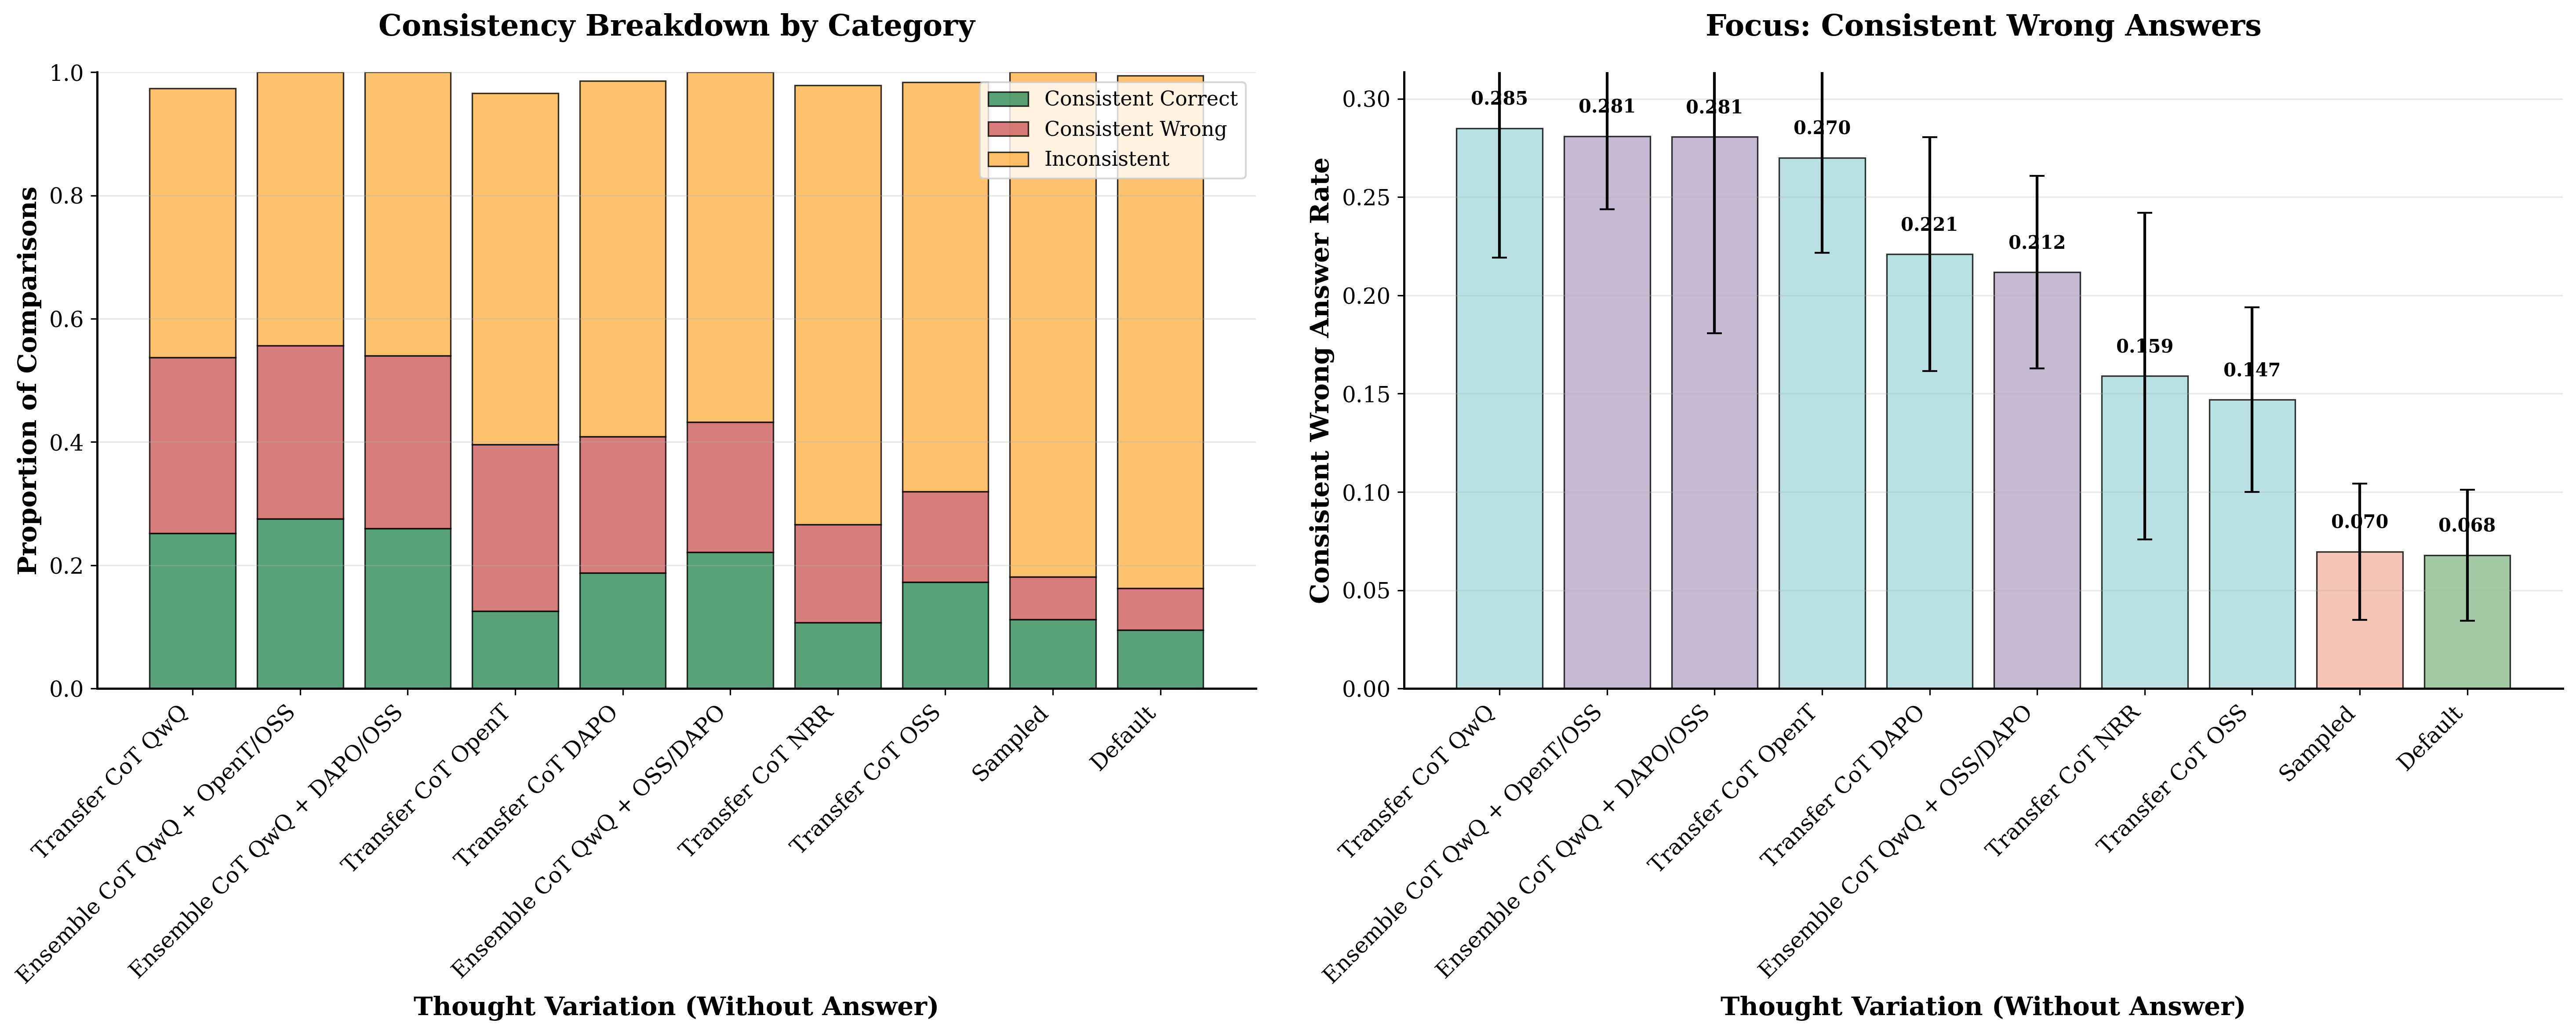


DETAILED CONSISTENCY ANALYSIS
Analysis of 10 variations (without answer):

 1. Transfer CoT QwQ
     Consistent Correct: 0.252 ± 0.037 (n=10)
     Consistent Wrong  : 0.285 ± 0.066 (n=10)
     Inconsistent      : 0.437 ± 0.097 (n=10)
     Consistent Mixed  : 0.026 ± 0.009 (n=10)
     Total Consistent  : 0.537
     Wrong/Total Cons. : 0.531

 2. Ensemble CoT QwQ + OpenT/OSS
     Consistent Correct: 0.276 ± 0.046 (n=10)
     Consistent Wrong  : 0.281 ± 0.037 (n=10)
     Inconsistent      : 0.443 ± 0.080 (n=10)
     Total Consistent  : 0.557
     Wrong/Total Cons. : 0.505

 3. Ensemble CoT QwQ + DAPO/OSS
     Consistent Correct: 0.260 ± 0.032 (n=10)
     Consistent Wrong  : 0.281 ± 0.100 (n=10)
     Inconsistent      : 0.460 ± 0.129 (n=10)
     Total Consistent  : 0.540
     Wrong/Total Cons. : 0.519

 4. Transfer CoT OpenT
     Consistent Correct: 0.126 ± 0.028 (n=10)
     Consistent Wrong  : 0.270 ± 0.048 (n=10)
     Inconsistent      : 0.570 ± 0.076 (n=10)
     Consistent Mixed  : 0.0

In [1]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.patches import Patch
import warnings
warnings.filterwarnings('ignore')

# Configuration
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'DejaVu Serif'],
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 11,
    'figure.dpi': 300
})

MODEL_NAMES = {
    'openai_gpt-oss-20b': 'OSS',
    'BytedTsinghua-SIA_DAPO-Qwen-32B': 'DAPO', 
    'Qwen_QwQ-32B': 'QwQ',
    'open-thoughts_OpenThinker-7B': 'OpenT',
    'nvidia_Nemotron-Research-Reasoning-Qwen-1.5B': 'NRR'
}

COLORS = {
    'empty': '#E8E8E8',
    'default': '#8FBC8F', 
    'sampled': '#F0B7A4',
    'transfer': '#A8DADC', 
    'ensemble': '#B8A9C9'
}

def parse_jsonl(filepath):
    """Parse JSONL file and return list of dictionaries."""
    try:
        with open(filepath, 'r') as f:
            return [json.loads(line) for line in f if line.strip()]
    except:
        return []

def get_variation(filename):
    """Extract variation type from filename."""
    suffix = 'without ans' if 'without_answer' in filename else 'full text'
    
    if '_zero_shot_empty.jsonl' in filename:
        return ['Empty']
    elif '_zero_shot_original.jsonl' in filename or '_zero_shot_original_low.jsonl' in filename:
        return [f'Default {suffix}']
    elif '_with_sampling' in filename:
        return [f'Sampled {suffix}']
    
    # Transfer CoT
    match = re.match(r'(.+)_thoughts_to_(.+)_zero_shot', filename)
    if match:
        source, target = match.groups()
        short_source = MODEL_NAMES.get(source, source)
        if source == target and "without_answer" in filename:
            return [f'Default {suffix}', f'Transfer CoT {short_source} {suffix}']
        else:
            return [f'Transfer CoT {short_source} {suffix}']
    
    # Ensemble CoT
    if '_gen_' in filename and '_eval_' in filename:
        gen = re.search(r'_gen_(.+)_eval', filename)
        eval_match = re.search(r'_eval_(.+).json', filename)
        if gen and eval_match:
            gen_short = MODEL_NAMES.get(gen.group(1), gen.group(1))
            eval_short = MODEL_NAMES.get(eval_match.group(1), eval_match.group(1))
            
            # Handle special combinations
            gen_mappings = {
                "qwq_dapo": "QwQ + DAPO",
                "qwq_opent": "QwQ + OpenT", 
                "qwq_oss": "QwQ + OSS"
            }
            gen_short = gen_mappings.get(gen_short, gen_short)
            eval_short = {"oss": "OSS", "dapo": "DAPO"}.get(eval_short, eval_short)
            
            return [f'Ensemble CoT {gen_short}/{eval_short} {suffix}']
    
    return []

def get_target_model(filename):
    """Extract target model from filename."""
    if '_thoughts_to_' in filename:
        match = re.match(r'.+_thoughts_to_(.+)_zero_shot', filename)
        return match.group(1) if match else None
    
    for model in MODEL_NAMES:
        if model in filename:
            return model
    return None

def check_consistency_detailed(dp1, dp2, is_thoughts_to):
    """Check consistency between two data points with detailed breakdown."""
    fields = ("Target Answer", "Target Result") if is_thoughts_to else ("LLM Answer", "Result")
    ans1, res1 = dp1.get(fields[0], ""), dp1.get(fields[1], "")
    ans2, res2 = dp2.get(fields[0], ""), dp2.get(fields[1], "")
    
    invalid = ["not defined", "N/A", "does not match", "are not permitted"]
    if any(p in ans1 or p in ans2 for p in invalid):
        return None
    
    # Detailed consistency analysis
    both_correct = (res1 == "Correct" and res2 == "Correct")
    both_incorrect = (res1 == "Incorrect" and res2 == "Incorrect")
    same_answer = (ans1 == ans2)
    
    if same_answer and both_correct:
        return 'consistent_correct'
    elif same_answer and both_incorrect:
        return 'consistent_wrong'
    elif same_answer and not both_correct and not both_incorrect:
        return 'consistent_mixed'  # Same answer but mixed correctness
    else:
        return 'inconsistent'

def calculate_consistency_breakdown(folder_path):
    """Calculate detailed consistency breakdown for all variations."""
    if not os.path.exists(folder_path):
        return {}
    
    variation_files = defaultdict(list)
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jsonl'):
            continue
        if "grpo" in filename.lower():
            continue
        if "meta-llama" in filename.lower():
            continue
        if "deepseek" in filename.lower():
            continue

            
        variations = get_variation(filename)
        target = get_target_model(filename)
        
        if variations and target:
            for variation in variations:
                variation_files[variation].append((target, filename))
    
    results = {}
    for variation, files in variation_files.items():
        if len(files) < 2:
            continue
            
        breakdown_counts = defaultdict(list)
        is_thoughts_to = '_thoughts_to_' in files[0][1]
        
        for i in range(len(files)):
            for j in range(i + 1, len(files)):
                data1 = parse_jsonl(os.path.join(folder_path, files[i][1]))
                data2 = parse_jsonl(os.path.join(folder_path, files[j][1]))
                
                if not data1 or not data2:
                    continue
                
                pair_breakdown = defaultdict(int)
                total = 0
                
                for dp1, dp2 in zip(data1, data2):
                    result = check_consistency_detailed(dp1, dp2, is_thoughts_to)
                    if result is not None:
                        total += 1
                        pair_breakdown[result] += 1
                
                if total > 0:
                    # Convert counts to rates for this pair
                    for category in pair_breakdown:
                        breakdown_counts[category].append(pair_breakdown[category] / total)
        
        if breakdown_counts:
            results[variation] = {}
            for category, rates in breakdown_counts.items():
                results[variation][category] = {
                    'mean': np.mean(rates),
                    'std': np.std(rates),
                    'count': len(rates)
                }
    
    return results

def lighten_color(color, factor=0.5):
    """Lighten a hex color by mixing with white."""
    color = color.lstrip('#')
    r, g, b = tuple(int(color[i:i+2], 16) for i in (0, 2, 4))
    r = int(r + (255 - r) * factor)
    g = int(g + (255 - g) * factor)  
    b = int(b + (255 - b) * factor)
    return f'#{r:02x}{g:02x}{b:02x}'

def get_color_for_variation(name):
    """Get color based on variation type."""
    name_lower = name.lower()
    for key, color in COLORS.items():
        if key in name_lower:
            return color
    return '#E2E2DF'

def group_and_sort_results(results, sort_by='consistent_wrong'):
    """Group results by base type and sort by specified metric."""
    grouped = {}
    for name, data in results.items():
        if name.endswith(' full text'):
            base = name.replace(' full text', '')
            grouped.setdefault(base, {})['full'] = data
        elif name.endswith(' without ans'):
            base = name.replace(' without ans', '')
            grouped.setdefault(base, {})['without'] = data
        else:
            grouped[name] = {'full': data}
    
    def sort_key(item):
        name, variants = item
        # Sort by the specified metric (default: consistent_wrong)
        scores = []
        for variant_data in variants.values():
            if sort_by in variant_data:
                scores.append(variant_data[sort_by]['mean'])
        return np.mean(scores) if scores else 0
    
    return sorted(grouped.items(), key=sort_key, reverse=True)

def plot_consistency_breakdown(results):
    """Create visualization focusing on consistency breakdown."""
    if not results:
        return []
    
    # Focus on "without ans" variants for the wrong answer analysis
    without_ans_results = {k: v for k, v in results.items() if 'without ans' in k}
    
    if not without_ans_results:
        print("No 'without ans' variants found for analysis.")
        return []
    
    # Sort by consistent_wrong rate
    sorted_items = sorted(without_ans_results.items(), 
                         key=lambda x: x[1].get('consistent_wrong', {}).get('mean', 0), 
                         reverse=True)
    
    names = [name.replace(' without ans', '') for name, _ in sorted_items]
    
    # Categories to plot
    categories = ['consistent_correct', 'consistent_wrong', 'inconsistent']
    category_labels = ['Consistent Correct', 'Consistent Wrong', 'Inconsistent']
    category_colors = ['#2E8B57', '#CD5C5C', '#FFB347']  # Green, Red, Orange
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot 1: Stacked bar chart
    x = np.arange(len(names))
    bottoms = np.zeros(len(names))
    
    for i, category in enumerate(categories):
        values = []
        errors = []
        for _, data in sorted_items:
            if category in data:
                values.append(data[category]['mean'])
                errors.append(data[category]['std'])
            else:
                values.append(0)
                errors.append(0)
        
        ax1.bar(x, values, bottom=bottoms, label=category_labels[i], 
                color=category_colors[i], alpha=0.8, edgecolor='black', linewidth=0.8)
        bottoms += np.array(values)
    
    ax1.set_xlabel('Thought Variation (Without Answer)', fontweight='bold', fontsize=14)
    ax1.set_ylabel('Proportion of Comparisons', fontweight='bold', fontsize=14)
    ax1.set_title('Consistency Breakdown by Category', fontweight='bold', fontsize=16, pad=20)
    ax1.set_xticks(x)
    ax1.set_xticklabels(names, rotation=45, ha='right')
    ax1.legend(loc='upper right')
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, 1)
    
    # Plot 2: Focus on consistent wrong answers
    wrong_values = []
    wrong_errors = []
    colors = []
    
    for name, data in sorted_items:
        if 'consistent_wrong' in data:
            wrong_values.append(data['consistent_wrong']['mean'])
            wrong_errors.append(data['consistent_wrong']['std'])
        else:
            wrong_values.append(0)
            wrong_errors.append(0)
        colors.append(get_color_for_variation(name))
    
    bars = ax2.bar(x, wrong_values, yerr=wrong_errors, capsize=4,
                   color=colors, alpha=0.8, edgecolor='black', linewidth=0.8)
    
    ax2.set_xlabel('Thought Variation (Without Answer)', fontweight='bold', fontsize=14)
    ax2.set_ylabel('Consistent Wrong Answer Rate', fontweight='bold', fontsize=14)
    ax2.set_title('Focus: Consistent Wrong Answers', fontweight='bold', fontsize=16, pad=20)
    ax2.set_xticks(x)
    ax2.set_xticklabels(names, rotation=45, ha='right')
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, max(wrong_values) * 1.1 if wrong_values else 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, wrong_values):
        if value > 0:
            ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{value:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='bold')
    
    # Style both plots
    for ax in [ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)
    
    plt.tight_layout()
    plt.savefig('consistency_wrong_analysis.pdf', bbox_inches='tight', dpi=300)
    plt.savefig('consistency_wrong_analysis.eps', bbox_inches='tight', dpi=300)
    plt.show()
    
    return sorted_items

def print_detailed_summary(results):
    """Print detailed summary with focus on wrong answer consistency."""
    print("\nDETAILED CONSISTENCY ANALYSIS")
    print("=" * 60)
    
    # Focus on without_ans variants
    without_ans_results = {k: v for k, v in results.items() if 'without ans' in k}
    
    if not without_ans_results:
        print("No 'without ans' variants found.")
        return
    
    sorted_items = sorted(without_ans_results.items(), 
                         key=lambda x: x[1].get('consistent_wrong', {}).get('mean', 0), 
                         reverse=True)
    
    print(f"Analysis of {len(sorted_items)} variations (without answer):")
    print()
    
    categories = [
        ('consistent_correct', 'Consistent Correct'),
        ('consistent_wrong', 'Consistent Wrong'), 
        ('inconsistent', 'Inconsistent'),
        ('consistent_mixed', 'Consistent Mixed')
    ]
    
    for i, (name, data) in enumerate(sorted_items):
        clean_name = name.replace(' without ans', '')
        print(f"{i+1:2d}. {clean_name}")
        
        for category, label in categories:
            if category in data:
                mean = data[category]['mean']
                std = data[category]['std']
                count = data[category]['count']
                print(f"     {label:18}: {mean:.3f} ± {std:.3f} (n={count})")
        
        # Calculate total consistency (correct + wrong)
        total_consistent = 0
        if 'consistent_correct' in data and 'consistent_wrong' in data:
            total_consistent = data['consistent_correct']['mean'] + data['consistent_wrong']['mean']
            print(f"     {'Total Consistent':18}: {total_consistent:.3f}")
            
            # Wrong answer proportion of total consistency
            if total_consistent > 0:
                wrong_prop = data['consistent_wrong']['mean'] / total_consistent
                print(f"     {'Wrong/Total Cons.':18}: {wrong_prop:.3f}")
        
        print()

def main(folder_path):
    """Main execution function."""
    print("Consistency Analysis with Wrong Answer Breakdown")
    print(f"Folder: {folder_path}")
    print("-" * 50)
    
    results = calculate_consistency_breakdown(folder_path)
    
    if not results:
        print("No valid comparisons found.")
        return
    
    print(f"Found {len(results)} variations")
    sorted_items = plot_consistency_breakdown(results)
    print_detailed_summary(results)
    
    # Additional analysis: focus on highest wrong consistency rates
    print("\nTOP VARIATIONS BY CONSISTENT WRONG RATE:")
    print("-" * 40)
    
    without_ans_results = {k: v for k, v in results.items() if 'without ans' in k}
    top_wrong = sorted(without_ans_results.items(), 
                      key=lambda x: x[1].get('consistent_wrong', {}).get('mean', 0), 
                      reverse=True)
    
    for i, (name, data) in enumerate(top_wrong[:5]):
        if 'consistent_wrong' in data:
            rate = data['consistent_wrong']['mean']
            std = data['consistent_wrong']['std']
            clean_name = name.replace(' without ans', '')
            print(f"{i+1}. {clean_name}: {rate:.3f} ± {std:.3f}")
    
    print("\nAnalysis complete.")

if __name__ == "__main__":
    main("../outputs")